In [2]:
!pip install tensorflow==2.15.0
!pip install tensorflow-quantum==0.7.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# Cirq and parameterized quantum circuits

In [4]:
a, b = sympy.symbols('a b')

In [4]:
a

a

These **symbolic variables** will be used later to define the **rotation angles for the quantum gates**.

In [5]:
# Create two qubits [q0,q1]
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create a circuit on these qubits using the parameters you created above.
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1),
    cirq.CNOT(q0, q1))

In [11]:
q0

cirq.GridQubit(0, 0)

In [12]:
q1

cirq.GridQubit(0, 1)

1. **cirq.rx(a).on(q0)**: This applies a **rotation** around the **x-axis (RX gate) **to the qubit q0 **using the angle a**. The rotation will affect the state of the qubit based on the value of a.
2. **cirq.ry(b).on(q1)**: This applies a **rotation** around **the y-axis (RY gate)** to the qubit q1 using the **angle b**.
3. **cirq.CNOT(q0, q1)**: This applies a **CNOT** (controlled-NOT) gate where **q0 is the control qubit** and q1 is the target qubit.** If q0 is in state |1⟩, the state of q1 is flipped**, otherwise it stays the same.

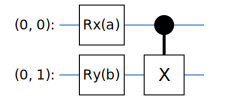

In [6]:
SVGCircuit(circuit)

To **evaluate circuits**, you can use the **cirq.Simulator interface**. You replace **free parameters** in a circuit with specific numbers by passing in a cirq.ParamResolver object. The following code calculates the raw state vector output of your parameterized circuit:

In [7]:
# Calculate a state vector with a=0.5 and b=-0.5.
resolver=cirq.ParamResolver({a:0.5,b:-0.5})
simulation=cirq.Simulator().simulate(circuit,resolver)

In [9]:
simulation

measurements: (no measurements)

qubits: (cirq.GridQubit(0, 0), cirq.GridQubit(0, 1))
output vector: 0.939|00⟩ - 0.24|01⟩ + 0.061j|10⟩ - 0.24j|11⟩

phase:
output vector: |⟩

In [8]:
out_state_vect=simulation.final_state_vector
out_state_vect

array([ 0.9387913 +0.j        , -0.23971277+0.j        ,
        0.        +0.06120872j,  0.        -0.23971277j], dtype=complex64)

State vectors **are not directly accessible outside of simulation** (notice the complex numbers in the output above). To be **physically realistic**, you must **specify a measurement**, which **converts a state vector into a real number** that classical computers can understand.

Cirq specifies measurements **using combinations of the Pauli operators** X, Y and Z.

In [9]:
z0 = cirq.Z(q0)
z0x1 = 0.5 * z0 + cirq.X(q1)

In [10]:
qubit_map = {q0: 0, q1: 1}

This dictionary maps each qubit to its respective index in the output state vector.
Here, **q0 is mapped to index 0**, and **q1 is mapped to index 1**. This mapping is crucial for interpreting the state vector in relation to the qubits.

In [16]:
expected_im=z0.expectation_from_state_vector(out_state_vect, qubit_map)
expected_im

(0.8775825500488281+0j)

In [17]:
expected_real=expected_im.real
expected_real

0.8775825500488281

In [19]:
z0x1.expectation_from_state_vector(out_state_vect, qubit_map).real

-0.04063427448272705

# Quantum circuits as tensor

TensorFlow Quantum (TFQ) provides tfq.convert_to_tensor, a function that **converts Cirq objects into tensors**. This allows you **to send Cirq objects to our quantum layers and quantum ops**. The function can be called on lists or arrays of Cirq Circuits and Cirq Paulis:

In [11]:
# Rank 1 tensor containing 1 circuit.
circuit_tensor = tfq.convert_to_tensor([circuit])

print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [12]:
# Rank 1 tensor containing 2 Pauli operators.
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
print(pauli_tensor.shape)
print(pauli_tensor.dtype)

(2,)
<dtype: 'string'>


# Batching circuit simulation

TFQ provides methods for computing:
1. Expectation values
2. samples
3. state vectors.
For now, let's focus on **expectation values**.

The **highest-level** interface for calculating expectation values is the **tfq.layers.Expectation** layer, which is a **tf.keras.Layer**. In its simplest form, this layer is **equivalent to simulating a parameterized circuit over many cirq.ParamResolvers**; however, TFQ allows **batching** following TensorFlow semantics, and circuits are simulated using efficient C++ code.

Create a **batch of values** to substitute for our a and b parameters:

In [13]:
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=float)

In [14]:
batch_vals

array([[4.74141534, 3.10633471],
       [2.4604672 , 2.62848287],
       [4.61871428, 5.67496986],
       [0.21070536, 0.05423244],
       [1.97558288, 1.99383613]])

In [15]:
cirq_results = []
cirq_simulator = cirq.Simulator()

for vals in batch_vals:
    resolver = cirq.ParamResolver({a: vals[0], b: vals[1]})
    final_state_vector = cirq_simulator.simulate(circuit, resolver).final_state_vector
    cirq_results.append([z0.expectation_from_state_vector(final_state_vector,qubit_map).real])

print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[ 0.02902222]
 [-0.77686459]
 [-0.09353775]
 [ 0.97788352]
 [-0.39382249]]


The **same operation** is simplified in TFQ:

In [16]:
tfq.layers.Expectation()(circuit,
                         symbol_names=[a, b],
                         symbol_values=batch_vals,
                         operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.02902383],
       [-0.776865  ],
       [-0.09353614],
       [ 0.9778835 ],
       [-0.39382327]], dtype=float32)>